## 캐글 산탄데르 고객 만족 예측 

캐글의 산탄데르 고객 만족 데이트 세트에 대해서 고객 만족 여부를 XGBoost 와 LightGBM 을 이용해서 예측해 보자. <br>
[데이터 출처](https://www.kaggle.com/c/santander-customer-satisfaction/data)
#### Dataset 간략한 설명
* 해당 dataset 은 370개 feature , 각 이름이 모두 익명 처리되 있기 때문에 그 것만으로는 어떤 속성인지 추정이 불가능<br>
* Label 명은 TARGET , Label 값은 불만을 가진 고객 = 1 , 만족하는 고객 = 0 
* 성능 평가 지표는 임계값 영향을 받지 않는 ROC_AUC 를 사용

In [31]:
import pandas as pd 
import numpy as np

cust_df = pd.read_csv("Santander_Customer_Satisfaction/train.csv",encoding='latin-1')
print(cust_df.shape,'\n')

print(cust_df.info(),'\n')

cust_df

(76020, 371) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB
None 



,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76015,151829,2,48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60926.490000,0
76016,151830,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118634.520000,0
76017,151835,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74028.150000,0
76018,151836,2,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84278.160000,0


해당 dataset 은 모든 데이터가 숫자형이라 인코딩이 필요 없고, NULL 값도 존재 하지 않는 것으로 확인 된다.<br><br>
우리가 필요한 feature 는 TARGET 이므로 데이터 값이 어떻게 분포 되어 있는지 확인이 필요하다.

In [32]:
print(cust_df['TARGET'].value_counts(),'\n')

unsatisfied_cnt = cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied ratio : ',unsatisfied_cnt/total_cnt * 100,'%')

0    73012
1     3008
Name: TARGET, dtype: int64 

unsatisfied ratio :  3.9568534596158904 %


아무리 NULL 값이 없더라도 각 feature 값들의 분포가 어떻게 구성 되는지 알아두는 것이 좋다.

In [33]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


feature name, var 3 에서 min 값이 이상한 것 같다. var3 이 어떤 feature 인지는 모르나, 25% 50% , max 값들을 보면 단순히 NaN 이나 특이값을 -999999로 변환 해둔 것 이라는 짐작을 할 수 있다. 

In [34]:
cust_df['var3'].replace(-999999,2,inplace=True)
cust_df.drop('ID',axis=1,inplace=True)

데이터 전처리가 대충 끝났으니 모델링을 위한 데이터 틀을 잡아두자.

In [35]:
X_features = cust_df.iloc[:,:-1]
y_labels = cust_df.iloc[:,-1]

print(X_features.shape)

(76020, 369)


학습 dataset , 테스트 dataset 분리 후 분석 

In [36]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X_features,y_labels,test_size=0.2,random_state =150)

train_cnt = y_train.count()
test_cnt = y_test.count()

print('피처 / 학습 세트 Shape:{0}, 테스트 세트 Shape:{1}\n'.format(X_train.shape,X_test.shape))

print('학습 세트 레이블 값 분포 비율\n',y_train.value_counts()/train_cnt)

print('\n테스트 세트 레이블 값 분포 비율\n',y_test.value_counts()/test_cnt)

피처 / 학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)

학습 세트 레이블 값 분포 비율
 0    0.960701
1    0.039299
Name: TARGET, dtype: float64

테스트 세트 레이블 값 분포 비율
 0    0.959353
1    0.040647
Name: TARGET, dtype: float64


### XGBoost 모델 학습과 하이퍼 파라미터 튜닝 

* XGBoost 학습 모델을 생성하고 예측 결과를 ROC AUC 로 평가 
* 평가 데이터는 테스트 데이터로 이용 - 과적합 가능성을 증가 시킬 수 있으니 염두 해두기 

In [37]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

xgb_clf = XGBClassifier(n_estimators=500, random_state=152)
xgb_clf.fit(X_train,y_train,early_stopping_rounds=100,eval_metric='auc',eval_set=[(X_train,y_train),(X_test,y_test)])

xgb_roc_score = roc_auc_score(y_test,xgb_clf.predict_proba(X_test)[:,1],average='macro')

print('ROC AUC : {0:.3f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82496	validation_1-auc:0.81473
[1]	validation_0-auc:0.83359	validation_1-auc:0.82282
[2]	validation_0-auc:0.84137	validation_1-auc:0.82665
[3]	validation_0-auc:0.84633	validation_1-auc:0.82918
[4]	validation_0-auc:0.84861	validation_1-auc:0.82973
[5]	validation_0-auc:0.85185	validation_1-auc:0.83182
[6]	validation_0-auc:0.85599	validation_1-auc:0.83561
[7]	validation_0-auc:0.85908	validation_1-auc:0.83554
[8]	validation_0-auc:0.86367	validation_1-auc:0.83485
[9]	validation_0-auc:0.86616	validation_1-auc:0.83632
[10]	validation_0-auc:0.86949	validation_1-auc:0.83733
[11]	validation_0-auc:0.87153	validation_1-auc:0.83751
[12]	validation_0-auc:0.87418	validation_1-auc:0.83832
[13]	validation_0-auc:0.87696	validation_1-auc:0.83890
[14]	validation_0-auc:0.87867	validation_1-auc:0.83840
[15]	validation_0-auc:0.88074	validation_1-auc:0.83924
[16]	validation_0-auc:0.88313	validation_1-auc:0.84013
[17]	validation_0-auc:0.88407	validation_1-auc:0.83973
[18]	validation_0-au

GridSearchCV 하이퍼 파라미터 튜닝 적용<br>
반복 결과를 하나 하나 확인 하고 싶다면 verbose = True 사용

In [38]:
from sklearn.model_selection import GridSearchCV

xgb_clf = XGBClassifier(n_estimators=100)

params = {'max_depth':[5,7],
         'min_child_weight':[1,3],
         'colsample_bytree':[0.5,0.75]}

gridcv = GridSearchCV(xgb_clf,param_grid=params,cv=3)
gridcv.fit(X_train,y_train,early_stopping_rounds=30,eval_metric='auc',eval_set=[(X_train,y_train),(X_test,y_test)],verbose=0)

print("GridSearchCV 최적 파라미터 :",gridcv.best_params_)

xgb_roc_score = roc_auc_score(y_test,gridcv.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC : {0:.4f}'.format(xgb_roc_score))

GridSearchCV 최적 파라미터 : {'colsample_bytree': 0.75, 'max_depth': 5, 'min_child_weight': 1}
ROC AUC : 0.8407


GridSearchCV 에서 찾아낸 최적의 하이퍼 파라미터에서 살짝 변경해서 알고리즘에 생성자로 직접 입력해서 튜닝 진행

In [39]:
xgb_clf = XGBClassifier(n_estimators=1000,random_state=100, learning_rate=0.02,max_depth=5,min_child_weight=1,colsample_bytree=0.75,
                       reg_alpha=0.03)

xgb_clf.fit(X_train,y_train,early_stopping_rounds=200,eval_metric='auc',eval_set=[(X_train,y_train),(X_test,y_test)],verbose=0)

xgb_roc_score = roc_auc_score(y_test,xgb_clf.predict_proba(X_test)[:,1],average='macro')

print("ROC AUC : {0:.4f}".format(xgb_roc_score))

ROC AUC : 0.8419


피처 중요도 확인

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

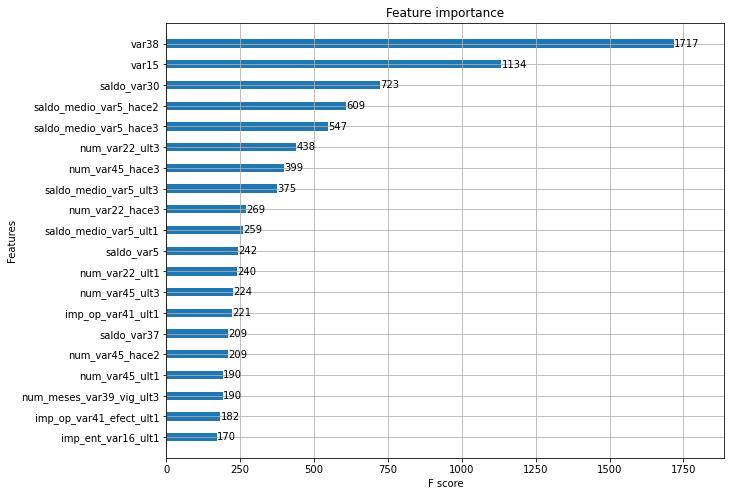

In [40]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf,ax=ax,max_num_features=20,height=0.4)

### LightGBM 모델 학습과 하이퍼 파라미터 튜닝 

학습 모델링 및 예측의 특이사항은 XGBoost 와 동일 <br>

기본 사용법

In [41]:
from lightgbm import LGBMClassifier
lgbm_clf = LGBMClassifier(n_estimators=500)
lgbm_clf.fit(X_train,y_train,early_stopping_rounds=100,eval_metric='auc',eval_set=[(X_test,y_test)],verbose=True)

lgbm_roc_score = roc_auc_score(y_test,lgbm_clf.predict_proba(X_test)[:,1],average='macro')

print("ROC AUC: {0:.4f}".format(lgbm_roc_score))

[1]	valid_0's auc: 0.80523	valid_0's binary_logloss: 0.162185
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.820989	valid_0's binary_logloss: 0.157329
[3]	valid_0's auc: 0.821823	valid_0's binary_logloss: 0.15392
[4]	valid_0's auc: 0.825245	valid_0's binary_logloss: 0.1513
[5]	valid_0's auc: 0.827694	valid_0's binary_logloss: 0.149172
[6]	valid_0's auc: 0.829718	valid_0's binary_logloss: 0.14741
[7]	valid_0's auc: 0.831063	valid_0's binary_logloss: 0.146147
[8]	valid_0's auc: 0.83222	valid_0's binary_logloss: 0.144933
[9]	valid_0's auc: 0.832337	valid_0's binary_logloss: 0.143936
[10]	valid_0's auc: 0.833799	valid_0's binary_logloss: 0.143116
[11]	valid_0's auc: 0.834453	valid_0's binary_logloss: 0.142415
[12]	valid_0's auc: 0.834595	valid_0's binary_logloss: 0.141843
[13]	valid_0's auc: 0.835167	valid_0's binary_logloss: 0.141234
[14]	valid_0's auc: 0.834653	valid_0's binary_logloss: 0.140931
[15]	valid_0's auc: 0.834792	valid_0's binary_logloss: 0.

GridSearchCV 하이퍼 파라미터 튜닝 적용<br>
반복 결과를 하나 하나 확인 하고 싶다면 verbose = True 사용

In [45]:
lgbm_clf = LGBMClassifier(n_estimators=200)

params = {'max_depth':[128,160],
         'num_leaves':[32,64],
         'min_child_samples':[60,100],
         'subsample':[0.8,1]}
gridcv = GridSearchCV(lgbm_clf,param_grid=params,cv=3)

gridcv.fit(X_train,y_train,early_stopping_rounds=30,eval_metric='auc',eval_set=[(X_train,y_train),(X_test,y_test)],verbose=0)

print("GridSearchCV 최적 파라미터 : ",gridcv.best_params_)

lgbm_roc_score = roc_auc_score(y_test,gridcv.predict_proba(X_test)[:,1],average="macro")

print("ROC AUC : {0:.4f}".format(lgbm_roc_score))

GridSearchCV 최적 파라미터 :  {'max_depth': 128, 'min_child_samples': 60, 'num_leaves': 64, 'subsample': 0.8}
ROC AUC : 0.8362


GridSearchCV 에서 찾아낸 최적의 하이퍼 파라미터에서 살짝 변경해서 알고리즘에 생성자로 직접 입력해서 튜닝 진행

In [48]:
lgbm_clf = LGBMClassifier(n_estimators=1000,num_leaves=64,subsample=0.8,max_depth=128,min_child_samples=60)

lgbm_clf.fit(X_train,y_train,early_stopping_rounds=100,eval_metric='auc',eval_set=[(X_test,y_test)])

lgbm_roc_score = roc_auc_score(y_test,lgbm_clf.predict_proba(X_test)[:,1],average='macro')

print("ROC AUC : {0:.4f}".format(lgbm_roc_score))

[1]	valid_0's auc: 0.814214	valid_0's binary_logloss: 0.161887
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.823023	valid_0's binary_logloss: 0.156976
[3]	valid_0's auc: 0.824121	valid_0's binary_logloss: 0.153536
[4]	valid_0's auc: 0.828624	valid_0's binary_logloss: 0.150847
[5]	valid_0's auc: 0.831406	valid_0's binary_logloss: 0.148654
[6]	valid_0's auc: 0.833316	valid_0's binary_logloss: 0.146832
[7]	valid_0's auc: 0.832792	valid_0's binary_logloss: 0.145524
[8]	valid_0's auc: 0.833251	valid_0's binary_logloss: 0.144371
[9]	valid_0's auc: 0.833212	valid_0's binary_logloss: 0.143518
[10]	valid_0's auc: 0.833134	valid_0's binary_logloss: 0.142748
[11]	valid_0's auc: 0.832786	valid_0's binary_logloss: 0.142096
[12]	valid_0's auc: 0.832881	valid_0's binary_logloss: 0.141574
[13]	valid_0's auc: 0.832262	valid_0's binary_logloss: 0.141128
[14]	valid_0's auc: 0.832166	valid_0's binary_logloss: 0.140791
[15]	valid_0's auc: 0.833964	valid_0's binary_loglo

XGBoost 와 LightGBM 을 통해서 고객 만족도에 대한 예측을 진행하였고 성능 평가 지표로 ROC AUC 값을 도출 해내었다.<br>
이 처럼 dataset 에 대해서 단순 예측, 하이퍼 파라미터 튜닝 예측, 최적 하이퍼 파라미터에서 재 튜닝 예측 까지 3가지 흐름을 알아 보았다.<br><br>
물론 튜닝을 한다고 무작정 성능이 좋아지는 것은 아니며 해당 하이퍼 파라미터가 무엇을 의미하고, 어디에 영향을 주는지 까지 파악 해둘 필요가 있다.<br>
[LightGBM 공식 문서](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html) 를 늘 확인하자.<br>
[추가 참고 자료](https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc) 